In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import sklearn.svm as svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.externals import joblib

# 1. Make Vehicle Train, Test, Validation Dataset

In [2]:
# Loading + training,validation test split
cars0 = glob.glob('./vehicleDB/GTI/vehicles/Far/*.png')
cars1 = glob.glob('./vehicleDB/GTI/vehicles/MiddleClose/*.png')
cars2 = glob.glob('./vehicleDB/GTI/vehicles/Left/*.png')
cars3 = glob.glob('./vehicleDB/GTI/vehicles/Right/*.png')
#cars4 = glob.glob('./vehicles/KITTI_extracted/*.png')
#cars4 += glob.glob('./vehicles/augmentation/*.png')

notcars1 = glob.glob('./vehicleDB/GTI/non-vehicles/Far/*.png')
notcars1 += glob.glob('./vehicleDB/GTI/non-vehicles/MiddleClose/*.png')
notcars1 += glob.glob('./vehicleDB/GTI/non-vehicles/Left/*.png')
notcars1 += glob.glob('./vehicleDB/GTI/non-vehicles/Right/*.png')

# split 70% training 20% validation 10% test set
frac1 = 0.7
l0, l1, l2, l3, l5=len(cars0), len(cars1), len(cars2), len(cars3), len(notcars1)
L1 = (frac1*np.array([l0, l1, l2, l3, l5])).astype('int')

frac2 = 0.9
l0, l1, l2, l3, l5=len(cars0), len(cars1), len(cars2), len(cars3), len(notcars1)
L2 = (frac2*np.array([l0, l1, l2, l3, l5])).astype('int')

cars_train = cars0[:L1[0]] + cars1[:L1[1]] + cars2[:L1[2]] + cars3[:L1[3]]
notcars_train = notcars1[:L1[4]]

cars_val = cars0[L1[0]:L2[0]] + cars1[L1[1]:L2[1]] + cars2[L1[2]:L2[2]] + cars3[L1[3]:L2[3]]
notcars_val = notcars1[L1[4]:L2[4]]

cars_test = cars0[L2[0]:] + cars1[L2[1]:] + cars2[L2[2]:] + cars3[L2[3]:]
notcars_test = notcars1[L2[4]:]

In [3]:
L1,L2

(array([ 682,  350,  682,  682, 2730]), array([ 877,  450,  877,  877, 3510]))

In [4]:
print('Number of samples in cars training set: ', len(cars_train))
print('Number of samples in notcars training set: ', len(notcars_train))

print('Number of samples in cars validation set: ', len(cars_val))
print('Number of samples in notcars validation set: ', len(notcars_val))

print('Number of samples in cars test set: ',len(cars_test))
print('Number of samples in notcars test set: ',len(notcars_test))


Number of samples in cars training set:  2396
Number of samples in notcars training set:  2730
Number of samples in cars validation set:  685
Number of samples in notcars validation set:  780
Number of samples in cars test set:  344
Number of samples in notcars test set:  390


## Save Dataset

In [5]:
# Save the data for easy access
pickle_file = './trained_weight/datasets.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'cars_train': cars_train,
                'notcars_train': notcars_train,
                'cars_val': cars_val,
                'notcars_val': notcars_val,
                'cars_test': cars_test,
                'notcars_test': notcars_test
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


## Open Datasets and Display vehicle/non-vehicle

In [6]:
data_file = './trained_weight/datasets.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars_train = data['cars_train']
notcars_train = data['notcars_train']
cars_val = data['cars_val']
notcars_val = data['notcars_val']
cars_test = data['cars_test']
notcars_test = data['notcars_test']

In [7]:
i=22
a_car = plt.imread(cars_train[i])
not_a_car = plt.imread(notcars_train[i])
cars_train[i],notcars_train[i]

('./vehicleDB/GTI/vehicles/Far/image0503.png',
 './vehicleDB/GTI/non-vehicles/Far/image0503.png')

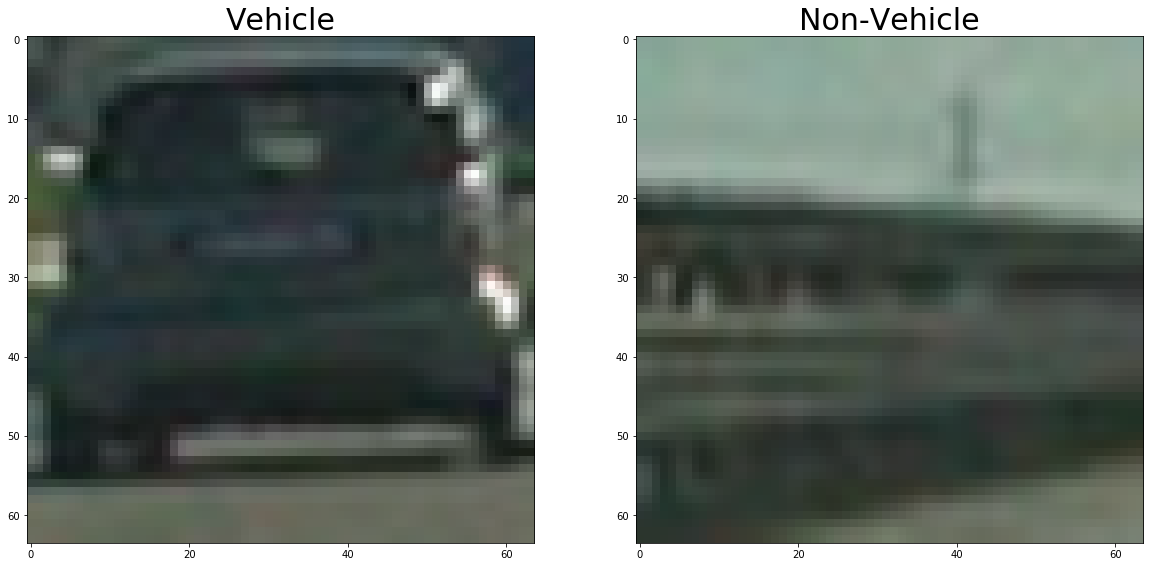

In [8]:
font_size=30
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(a_car)
ax1.set_title('Vehicle', fontsize=font_size)
ax2.imshow(not_a_car)
ax2.set_title('Non-Vehicle', fontsize=font_size)
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 
plt.show()

# 2. Train HOG and SVM

In [9]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

In [10]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [11]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [12]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [13]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [14]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [16]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [17]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Load the training validation and test data

In [18]:
data_file = './trained_weight/datasets.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars_train = data['cars_train']
cars_val   = data['cars_val']
cars_test  = data['cars_test']
notcars_train = data['notcars_train']
notcars_val   = data['notcars_val']
notcars_test  = data['notcars_test']

In [19]:
#helper function to extract features from files

def get_features(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:
        
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        features.append(img_features)
    return features

In [20]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
cars_train_feat = get_features(cars_train,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
cars_val_feat = get_features(cars_val,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
cars_test_feat = get_features(cars_test,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

notcars_train_feat = get_features(notcars_train,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_val_feat = get_features(notcars_val,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_test_feat = get_features(notcars_test,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG,spatial and color features...')

24.34 Seconds to extract HOG,spatial and color features...


In [21]:
# Create an array stack of feature vectors
X = np.vstack((cars_train_feat,cars_val_feat,cars_test_feat,
               notcars_train_feat,notcars_val_feat,notcars_test_feat)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [22]:
cars_ntrain=len(cars_train_feat)
cars_nval=len(cars_val_feat)
cars_ntest=len(cars_test_feat)
ncars_ntrain=len(notcars_train_feat)
ncars_nval=len(notcars_val_feat)
ncars_ntest=len(notcars_test_feat)

i1 = cars_ntrain
i2 = i1 + cars_nval
i3 = i2 + cars_ntest
i4 = i3 + ncars_ntrain
i5 = i4 + ncars_nval

cars_train_feat,cars_val_feat,cars_test_feat = scaled_X[:i1],scaled_X[i1:i2],scaled_X[i2:i3]
notcars_train_feat,notcars_val_feat,notcars_test_feat = scaled_X[i3:i4],scaled_X[i4:i5],scaled_X[i5:]

y_train = np.hstack((np.ones(cars_ntrain), np.zeros(ncars_ntrain)))
y_val = np.hstack((np.ones(cars_nval), np.zeros(ncars_nval)))
y_test = np.hstack((np.ones(cars_ntest), np.zeros(ncars_ntest)))

X_train = np.vstack((scaled_X[:i1],scaled_X[i3:i4]))
X_val = np.vstack((scaled_X[i1:i2],scaled_X[i4:i5]))
X_test = np.vstack((scaled_X[i2:i3],scaled_X[i5:]))

X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_val,y_val = shuffle(X_val,y_val,random_state=42)
X_test,y_test = shuffle(X_test,y_test,random_state=42)

In [23]:
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# use of the rbf kernel improves the accuracy by about another percent, 
# but increases the prediction time up to 1.7s(!) for 100 labels. Too slow.
#svc = svm.SVC(kernel='rbf')

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_val[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
0.94 Seconds to train SVC...
Validation Accuracy of SVC =  0.9809
Test Accuracy of SVC =  0.9728
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.
  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.
  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.
  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
For these 100 labels:  [ 0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.
  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.
  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.
  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.


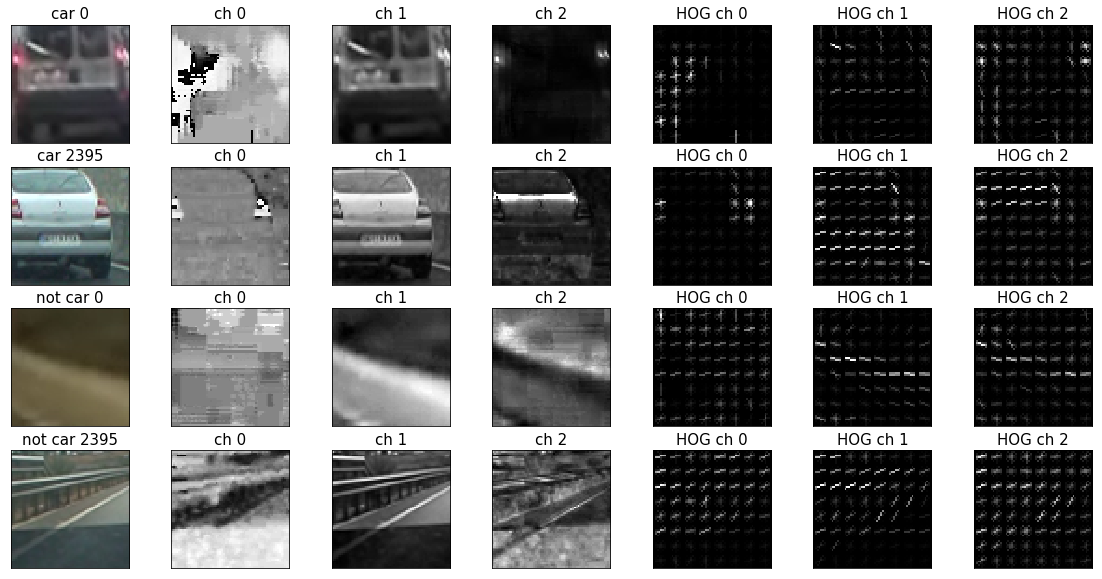

In [24]:
font_size=15
f, axarr = plt.subplots(4, 7,figsize=(20,10))
f.subplots_adjust(hspace=0.2, wspace=0.05)
colorspace = cv2.COLOR_RGB2HLS
#colorspace=cv2.COLOR_RGB2HSV
#colorspace=cv2.COLOR_RGB2YCrCb

#i1,i2=22,4000
i1 = 0

i2 = len(cars_train)-1
#print(i2)

for ind,j in enumerate([i1,i2]):
    #print(ind)
    #print(j)
    #print(cars_train[j])
    image = plt.imread(cars_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "car {0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])    
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
        
for indn,j in enumerate([i1,i2]):
    ind=indn+2
    image = plt.imread(notcars_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "not car {0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])        
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
              
plt.show()
#plt.savefig('./images/HOG_features_HLS.png')
#plt.savefig('./images/HOG_features_YCrCb.png')

number of misclassified car images 13
misclassified car image (0) : ./vehicleDB/GTI/vehicles/Far/image0485.png


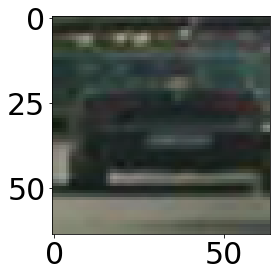

misclassified car image (1) : ./vehicleDB/GTI/vehicles/Far/image0119.png


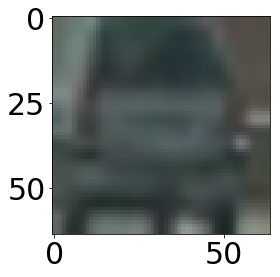

misclassified car image (2) : ./vehicleDB/GTI/vehicles/Far/image0300.png


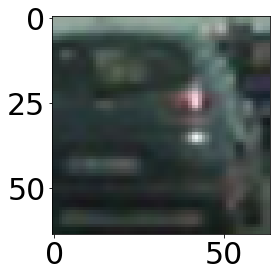

misclassified car image (3) : ./vehicleDB/GTI/vehicles/Far/image0112.png


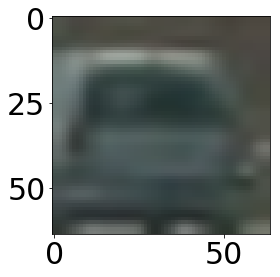

misclassified car image (4) : ./vehicleDB/GTI/vehicles/Left/image0457.png


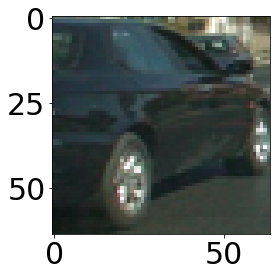

misclassified car image (5) : ./vehicleDB/GTI/vehicles/Left/image0320.png


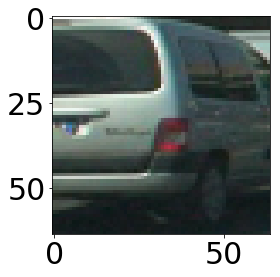

misclassified car image (6) : ./vehicleDB/GTI/vehicles/Right/image0627.png


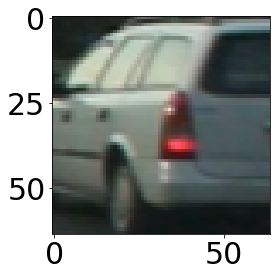

misclassified car image (7) : ./vehicleDB/GTI/vehicles/Right/image0302.png


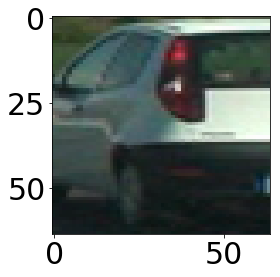

misclassified car image (8) : ./vehicleDB/GTI/vehicles/Right/image0596.png


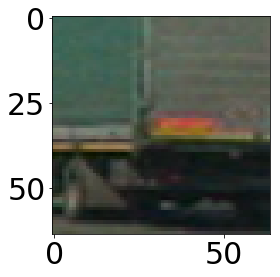

misclassified car image (9) : ./vehicleDB/GTI/vehicles/Right/image0930.png


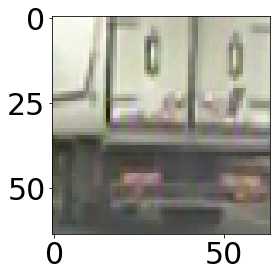

misclassified car image (10) : ./vehicleDB/GTI/vehicles/Right/image0052.png


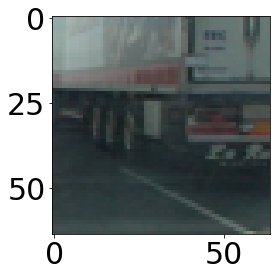

misclassified car image (11) : ./vehicleDB/GTI/vehicles/Right/image0638.png


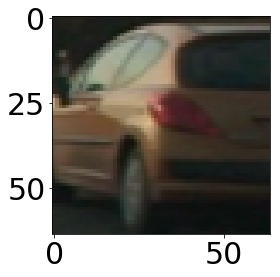

misclassified car image (12) : ./vehicleDB/GTI/vehicles/Right/image0521.png


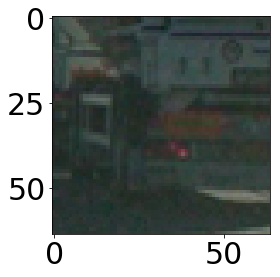

In [25]:
# plot false positives/negatives
font_size=15
preds = svc.predict(cars_val_feat)

misclassifieds = np.array(preds != np.ones(cars_nval))
inds = np.where(preds != np.ones(cars_nval))
inds = np.ravel(inds)
misclassifieds = [ cars_val[i] for i in inds]

print('number of misclassified car images',len(misclassifieds))

for i in range(len(inds)):
    print('misclassified car image ('+str(i)+') : '+misclassifieds[i])
    result = plt.imread(misclassifieds[i])
    plt.imshow(result)
    plt.show()
    

#plt.savefig('./images/false_negatives.png')

number of misclassified notcar images 15
misclassified notcar image (0) : ./vehicleDB/GTI/non-vehicles/Left/image0112.png


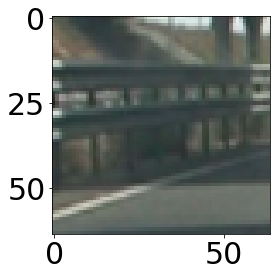

misclassified notcar image (1) : ./vehicleDB/GTI/non-vehicles/Left/image0354.png


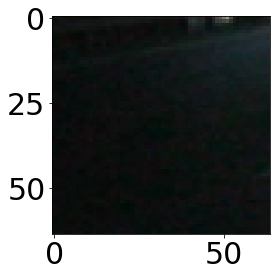

misclassified notcar image (2) : ./vehicleDB/GTI/non-vehicles/Right/image0037.png


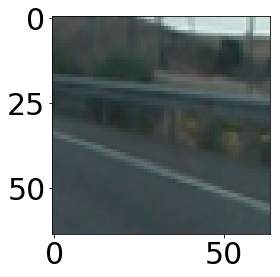

misclassified notcar image (3) : ./vehicleDB/GTI/non-vehicles/Right/image0724.png


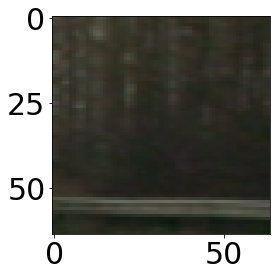

misclassified notcar image (4) : ./vehicleDB/GTI/non-vehicles/Right/image0528.png


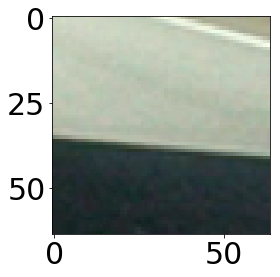

misclassified notcar image (5) : ./vehicleDB/GTI/non-vehicles/Right/image0105.png


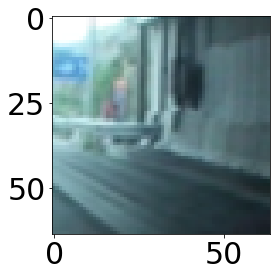

misclassified notcar image (6) : ./vehicleDB/GTI/non-vehicles/Right/image0088.png


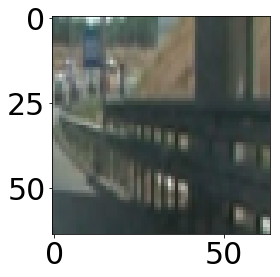

misclassified notcar image (7) : ./vehicleDB/GTI/non-vehicles/Right/image0050.png


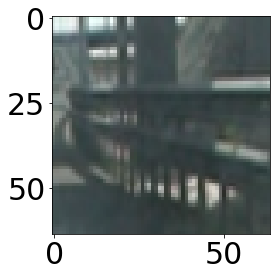

misclassified notcar image (8) : ./vehicleDB/GTI/non-vehicles/Right/image0714.png


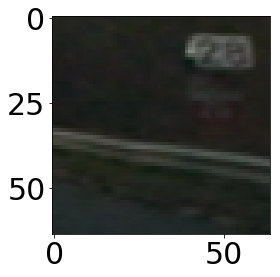

misclassified notcar image (9) : ./vehicleDB/GTI/non-vehicles/Right/image0832.png


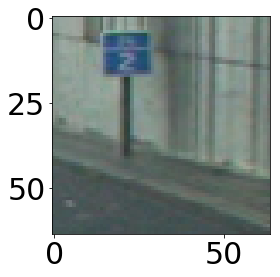

misclassified notcar image (10) : ./vehicleDB/GTI/non-vehicles/Right/image0719.png


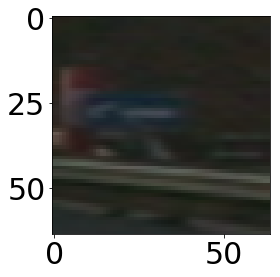

misclassified notcar image (11) : ./vehicleDB/GTI/non-vehicles/Right/image0546.png


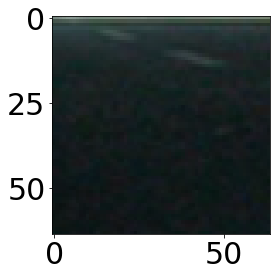

misclassified notcar image (12) : ./vehicleDB/GTI/non-vehicles/Right/image0759.png


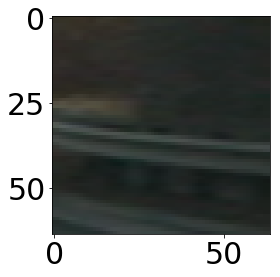

misclassified notcar image (13) : ./vehicleDB/GTI/non-vehicles/Right/image0893.png


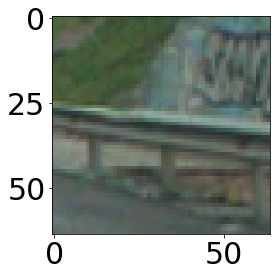

misclassified notcar image (14) : ./vehicleDB/GTI/non-vehicles/Right/image0158.png


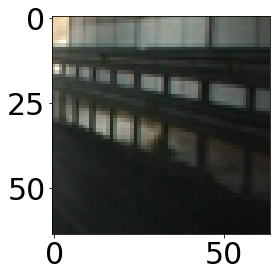

In [26]:
preds = svc.predict(notcars_val_feat)
inds = np.where(preds != np.zeros(ncars_nval))
inds = np.ravel(inds)
misclassifieds = [ notcars_val[i] for i in inds]

print('number of misclassified notcar images',len(misclassifieds))

for i in range(len(inds)):
    print('misclassified notcar image ('+str(i)+') : '+misclassifieds[i])
    result = plt.imread(misclassifieds[i])
    plt.imshow(result)
    plt.show()
#plt.savefig('./images/false_positives.png')


## Save Train Results

In [27]:
pickle_file = './trained_weight/HOG_SVM_Weight.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# 3. Vehicle Detection by HOG and SVM

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label

In [43]:
# Load the classifier and parameters
data_file = './trained_weight/HOG_SVM_Weight.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

In [44]:
images = sorted(glob.glob('test_images/out*.png'))
images

['test_images/out_2FPS_001.png',
 'test_images/out_2FPS_011.png',
 'test_images/out_2FPS_021.png',
 'test_images/out_2FPS_031.png',
 'test_images/out_2FPS_041.png',
 'test_images/out_2FPS_051.png',
 'test_images/out_2FPS_061.png',
 'test_images/out_2FPS_071.png',
 'test_images/out_2FPS_081.png',
 'test_images/out_2FPS_091.png']

In [45]:
#image = mpimg.imread('bbox-example-image.png')
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

def search_all_scales(image):
    
    hot_windows = []
    all_windows = []
    #Y_start_stop =[[300,460]]
    #XY_window = [(150,150)]
    #X_start_stop =[[None,None]]    
    #X_start_stop =[[None,None],[None,None],[None,None]]    
    #Y_start_stop =[[390,440],[400,560],[400,560]]    
    #XY_window = [(80,80),(110,110),(130,130)]

    X_start_stop =[[None,None],[None,None]]    
    Y_start_stop =[[390,470],[390,500]]    
    XY_window = [(64,64),(110,110)]
    XY_overlap=[(0.75, 0.75),(0.75, 0.75)]

    X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
    w0,w1,w2,w3 = 240,180,120,70
    o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    XY_window = [(w0,w0),(w1,w1),(w2,w2),(w3,w3)]
    XY_overlap = [(o0,o0),(o1,o1),(o2,o2),(o3,o3)]
    yi0,yi1,yi2,yi3 = 380,380,395,405                  
    Y_start_stop =[[yi0,yi0+w0/2],[yi1,yi1+w1/2],[yi2,yi2+w2/2],[yi3,yi3+w3/2]]    
    
    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

0.48 Seconds to search windows ...


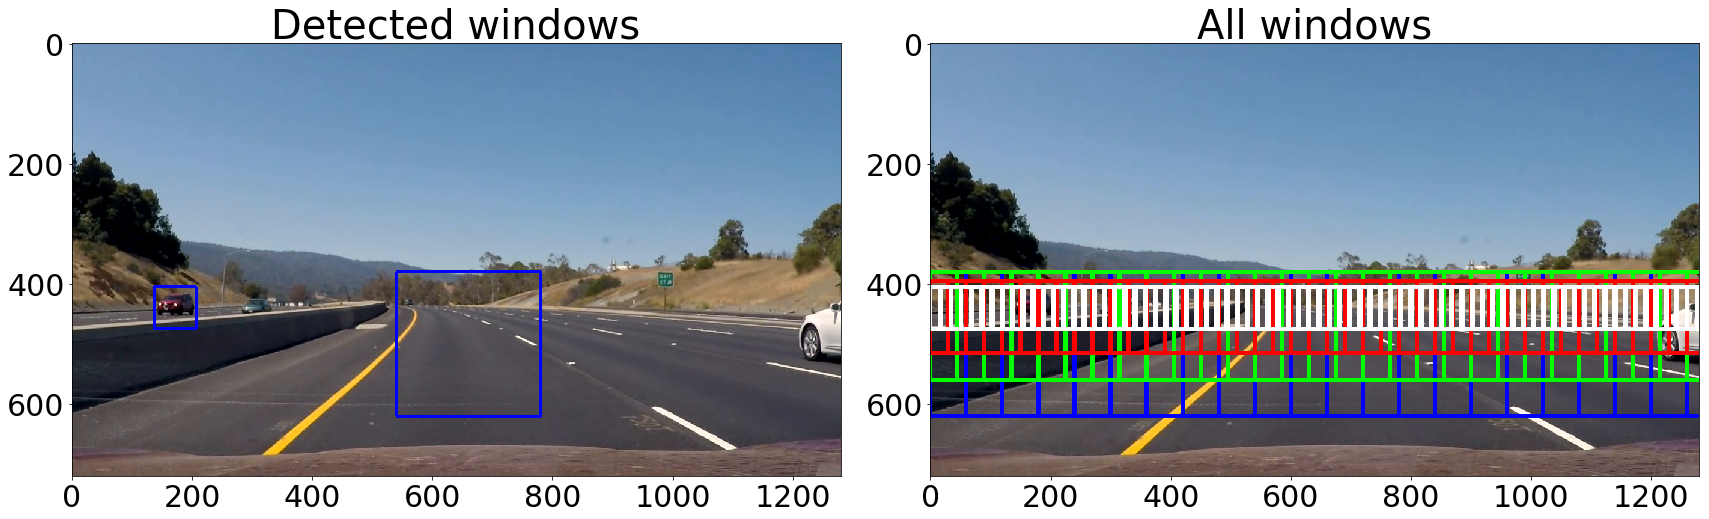

In [46]:
for file in images[1:2]:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    

    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    plt.show()
    #plt.savefig('images/sliding_windows.png')

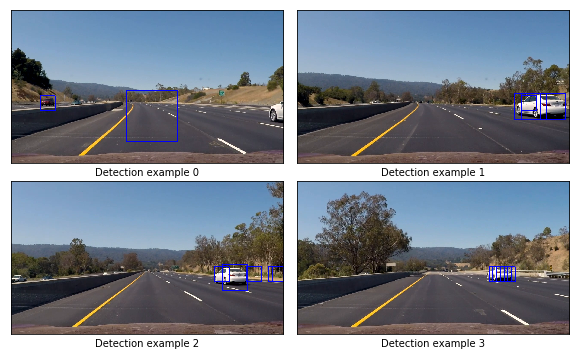

In [47]:
file0 = images[1]
file1 = images[2]
file2 = images[3]
file3 = images[4]

files = [file0,file1,file2,file3]

fig, axes = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(hspace=0.1, wspace=0.05)


for i, ax in enumerate(axes.flat):
    image = mpimg.imread(files[i])
    draw_image = np.copy(image)
    hot_windows,all_windows = search_all_scales(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
    ax.imshow(window_img)
    xlabel = "Detection example {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     

plt.show()
#plt.savefig('images/detection_example.png')

## Video Pipeline

In [48]:
# Define a class to receive the characteristics of bounding box detections
class BoundingBoxes:
    def __init__(self,n=10):
        # length of queue to store data
        self.n = n
        # hot windows of the last n images
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()
                
        
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    if bbox_list:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


0.47 Seconds to search windows ...
0.47 Seconds to search windows ...
0.47 Seconds to search windows ...
0.47 Seconds to search windows ...
0.47 Seconds to search windows ...
0.47 Seconds to search windows ...
0.47 Seconds to search windows ...
0.49 Seconds to search windows ...
0.49 Seconds to search windows ...


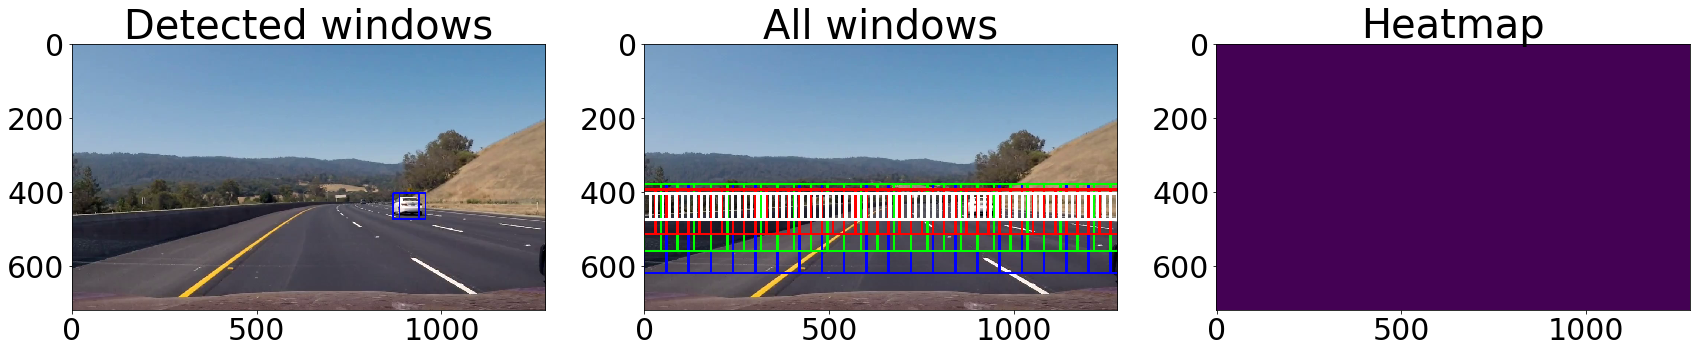

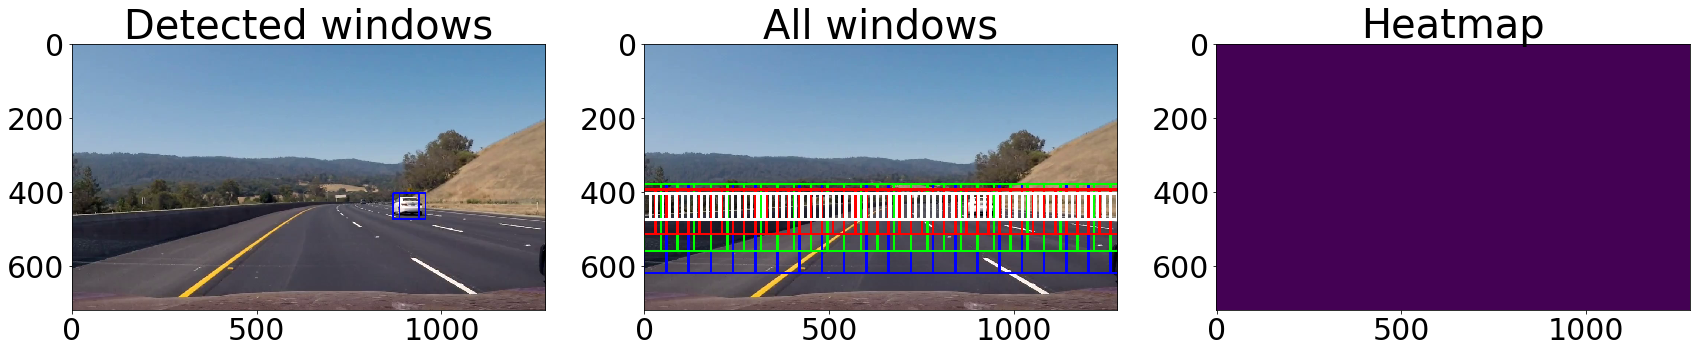

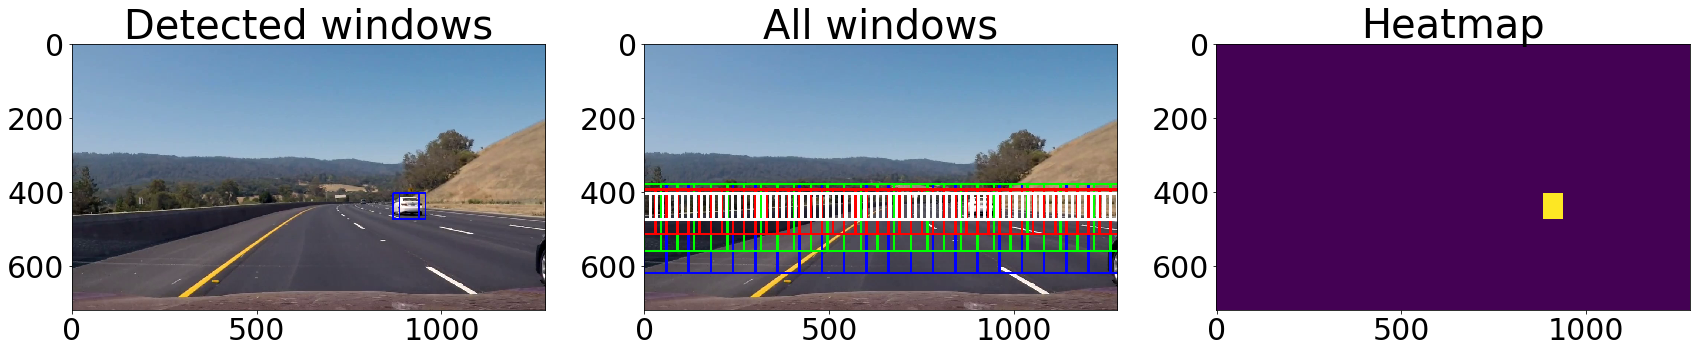

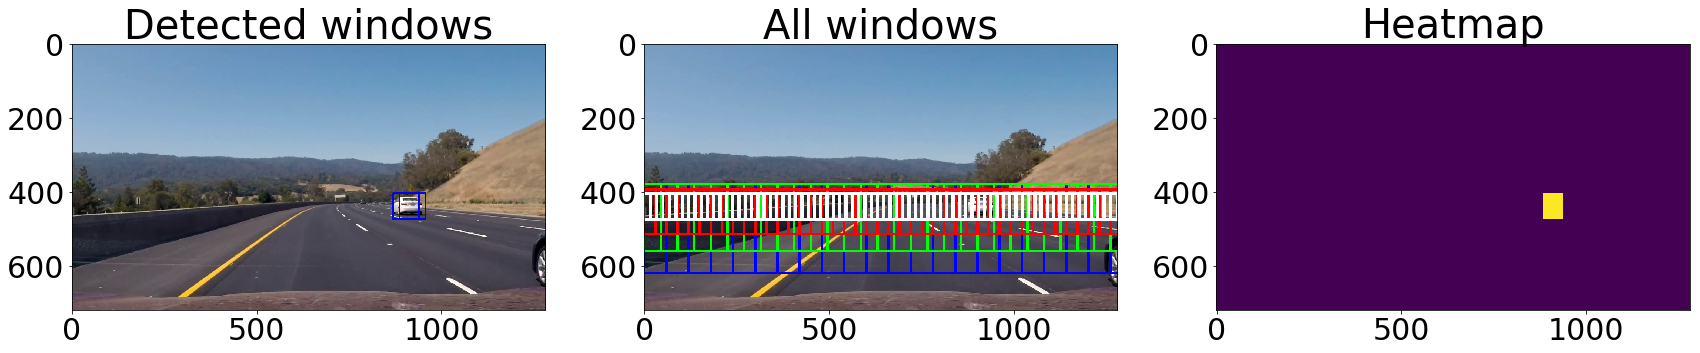

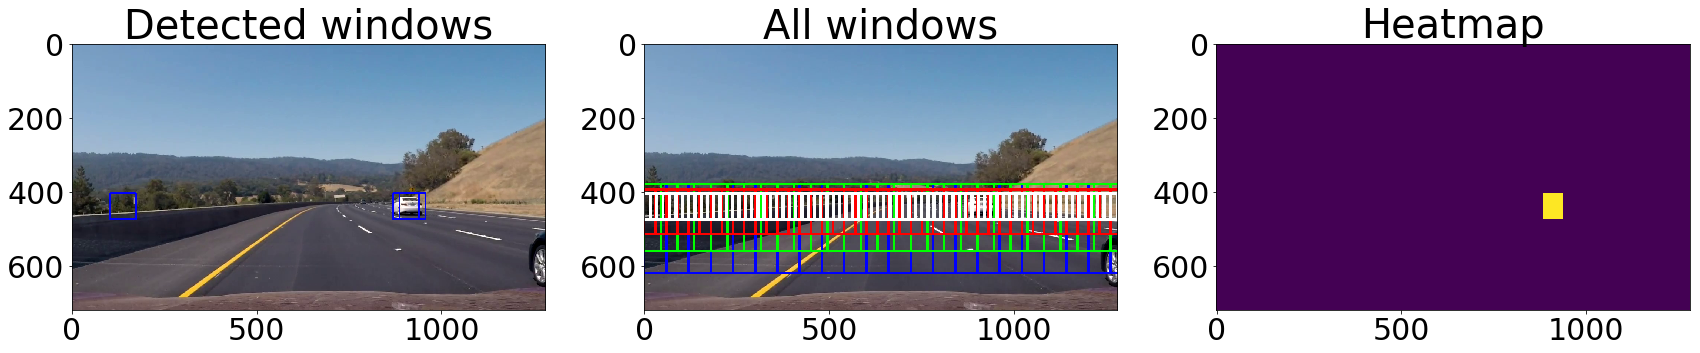

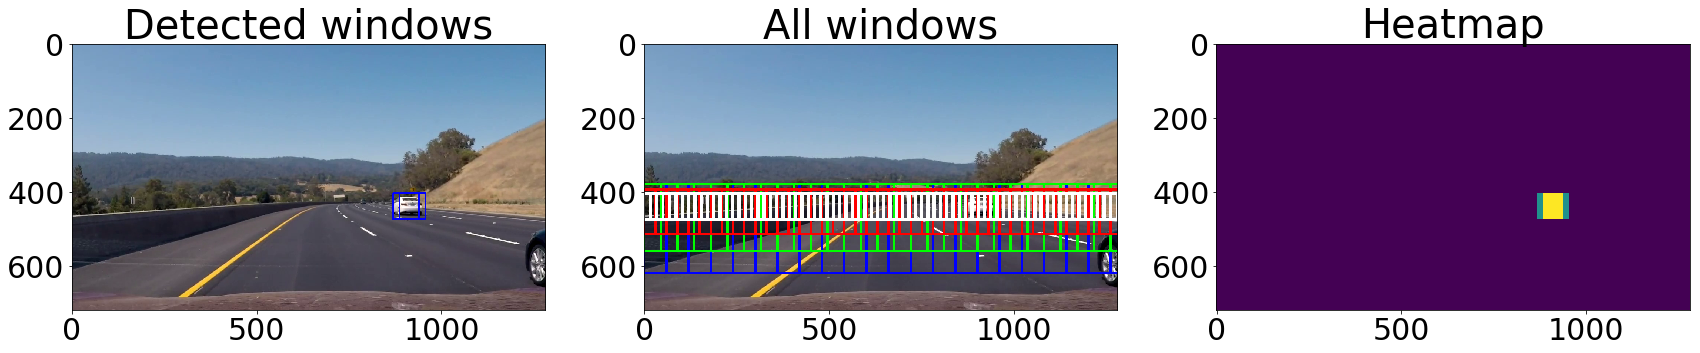

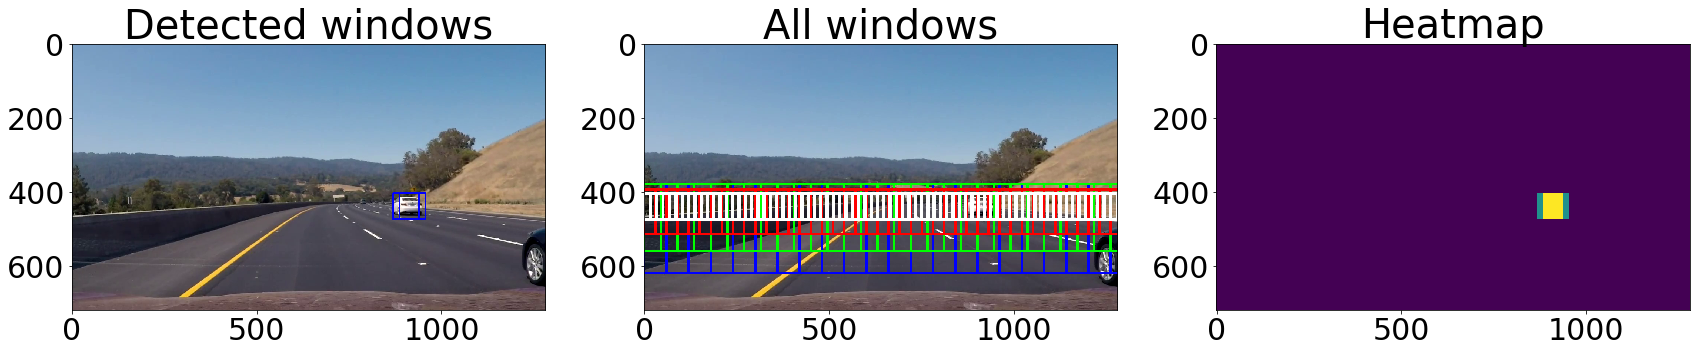

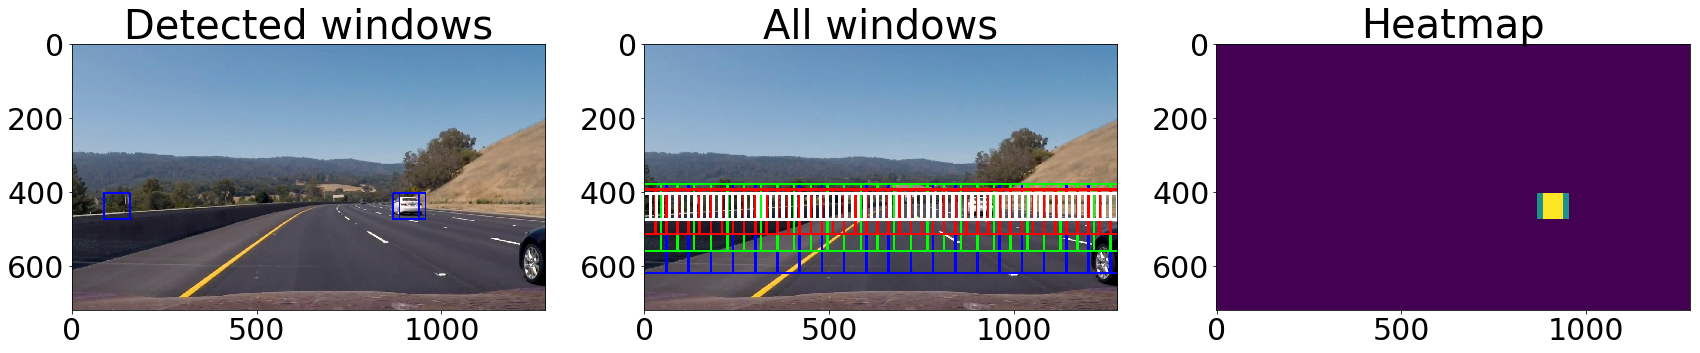

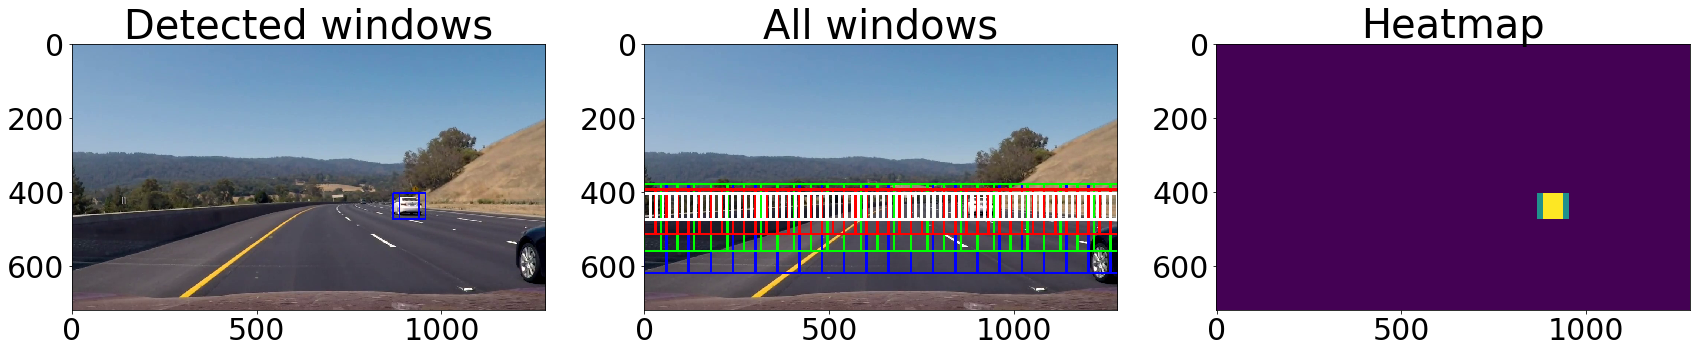

In [51]:
images = sorted(glob.glob('./heatmap/*.png'))
boxes = BoundingBoxes(n=6)

for file in images[0:9]:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    
    boxes.update(hot_windows)
    
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    # Read in the last image shown above 
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,5)
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    
    ax3.imshow(heatmap)
    ax3.set_title('Heatmap', fontsize=40)

plt.show()

1 cars found


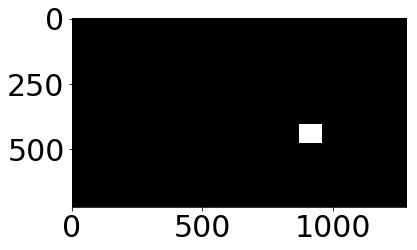

In [52]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

In [53]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

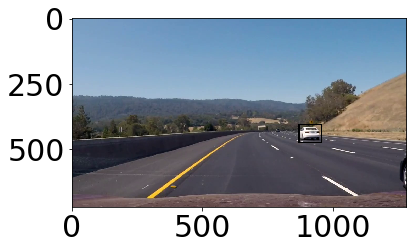

In [54]:
# Read in the last image above
image = mpimg.imread(images[2])
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(image, labels)
# Display the image
plt.imshow(draw_img)
plt.show()

## apply to video ##

In [55]:
boxes = BoundingBoxes(n=30)

def VehicleDetectionByHOGSVM(image):
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows,_ = search_all_scales(image)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,15)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    return window_image

In [56]:
project_video_output = './output_video/project_video_output_HOGSVM.mp4'
clip1 = VideoFileClip("./project_video.mp4")

In [57]:
lane_clip = clip1.fl_image(VehicleDetectionByHOGSVM) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video_output_HOGSVM.mp4
[MoviePy] Writing video ./output_video/project_video_output_HOGSVM.mp4


100%|█████████▉| 1260/1261 [10:25<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video_output_HOGSVM.mp4 

CPU times: user 10min 24s, sys: 1.54 s, total: 10min 25s
Wall time: 10min 26s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))